# ABC Crude Oil Revenue Forecasting - Complete Analysis

This notebook contains the complete implementation of the  crude oil revenue forecasting project, including data simulation, exploratory data analysis, time series modeling, scenario analysis, and visualization.

## Project Overview
- **Objective**: Forecast crude oil revenue using time series models
- **Data Period**: January 2013 - December 2024 (144 months)
- **Models**: ARIMA and Facebook Prophet
- **Scenario Analysis**: ±20% Brent price variations
- **Deliverables**: Forecasting models, dashboard, and comprehensive report

:## 1. Data Simulation and Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Generate simulated ABC Co. data (Jan 2013 - Dec 2024)
start_date = datetime(2013, 1, 1)
end_date = datetime(2024, 12, 31)
dates = pd.date_range(start=start_date, end=end_date, freq='MS')

# Simulate Crude Oil Production (Million Barrels)
production_base = 2.5
production = production_base + 0.5 * np.sin(np.arange(len(dates)) * np.pi / 6) + np.random.normal(0, 0.1, len(dates))
production = np.maximum(0.5, production)

# Simulate Brent Price (USD/barrel)
brent_price_base = 70
brent_price_trend = np.linspace(0, 10, len(dates))
brent_price_seasonality = 5 * np.sin(np.arange(len(dates)) * np.pi / 6)
brent_price_noise = np.random.normal(0, 3, len(dates))
brent_price = brent_price_base + brent_price_trend + brent_price_seasonality + brent_price_noise
brent_price = np.maximum(30, brent_price)

# Simulate USD-INR Exchange Rate
ex_rate_base = 60
ex_rate_trend = np.linspace(0, 25, len(dates))
ex_rate_noise = np.random.normal(0, 0.5, len(dates))
exchange_rate = ex_rate_base + ex_rate_trend + ex_rate_noise
exchange_rate = np.maximum(50, exchange_rate)

# Create DataFrame
df = pd.DataFrame({
    'Date': dates,
    'Production_MMBbl': production,
    'Brent_Price_USD': brent_price,
    'USD_INR_Exchange_Rate': exchange_rate
})

# Calculate Revenue and Profit
df['Estimated_Revenue_INR_Crore'] = df['Production_MMBbl'] * df['Brent_Price_USD'] * df['USD_INR_Exchange_Rate'] / 10

# Simulate Net Profit Margin
base_profit_margin = 0.18
profit_margin_noise = np.random.normal(0, 0.02, len(dates))
df['Net_Profit_Margin'] = base_profit_margin + profit_margin_noise
df['Net_Profit_Margin'] = np.clip(df['Net_Profit_Margin'], 0.05, 0.30)
df['Net_Profit_INR_Crore'] = df['Estimated_Revenue_INR_Crore'] * df['Net_Profit_Margin']

print(f"Dataset created with {len(df)} observations")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
df.head()

Dataset created with 144 observations
Date range: 2013-01-01 00:00:00 to 2024-12-01 00:00:00


,Date,Production_MMBbl,Brent_Price_USD,USD_INR_Exchange_Rate,Estimated_Revenue_INR_Crore,Net_Profit_Margin,Net_Profit_INR_Crore
0,2013-01-01,2.549671,70.779648,60.140496,1085.324535,0.174612,189.510539
1,2013-02-01,2.736174,74.915399,59.863475,1227.090701,0.194351,238.486115
2,2013-03-01,2.997782,70.759135,60.245589,1277.932028,0.210047,268.425969
3,2013-04-01,3.152303,71.248420,60.277975,1353.822875,0.181482,245.694342
4,2013-05-01,2.909597,76.175672,60.404618,1338.811189,0.212572,284.594188


## 2. Exploratory Data Analysis

In [3]:
# Basic statistics
print("Dataset Information:")
print(df.info())
print("\nDescriptive Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         144 non-null    datetime64[ns]
 1   Production_MMBbl             144 non-null    float64       
 2   Brent_Price_USD              144 non-null    float64       
 3   USD_INR_Exchange_Rate        144 non-null    float64       
 4   Estimated_Revenue_INR_Crore  144 non-null    float64       
 5   Net_Profit_Margin            144 non-null    float64       
 6   Net_Profit_INR_Crore         144 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 8.0 KB
None

Descriptive Statistics:
                      Date  Production_MMBbl  Brent_Price_USD  \
count                  144        144.000000       144.000000   
mean   2018-12-16 05:00:00          2.491908        75.176183   
min   

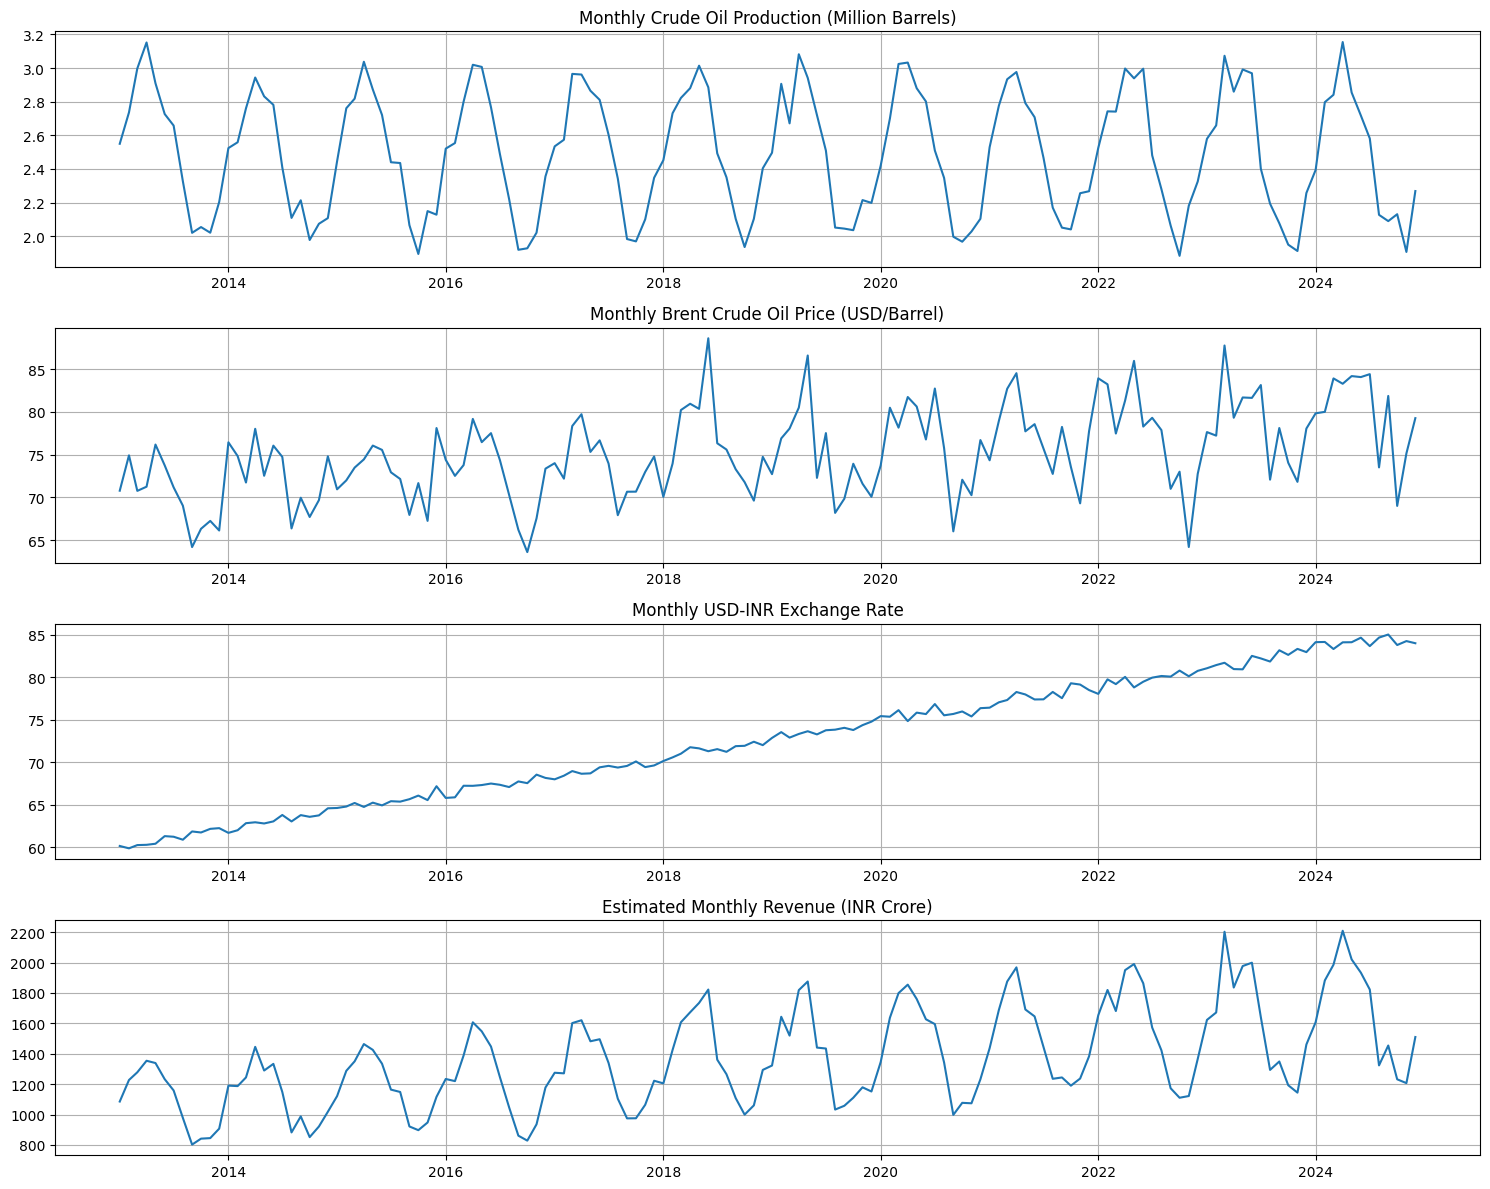

In [4]:
# Set Date as index for time series analysis
df_ts = df.set_index('Date')

# Plot time series trends
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

axes[0].plot(df_ts.index, df_ts['Production_MMBbl'])
axes[0].set_title('Monthly Crude Oil Production (Million Barrels)')
axes[0].grid(True)

axes[1].plot(df_ts.index, df_ts['Brent_Price_USD'])
axes[1].set_title('Monthly Brent Crude Oil Price (USD/Barrel)')
axes[1].grid(True)

axes[2].plot(df_ts.index, df_ts['USD_INR_Exchange_Rate'])
axes[2].set_title('Monthly USD-INR Exchange Rate')
axes[2].grid(True)

axes[3].plot(df_ts.index, df_ts['Estimated_Revenue_INR_Crore'])
axes[3].set_title('Estimated Monthly Revenue (INR Crore)')
axes[3].grid(True)

plt.tight_layout()
plt.show()

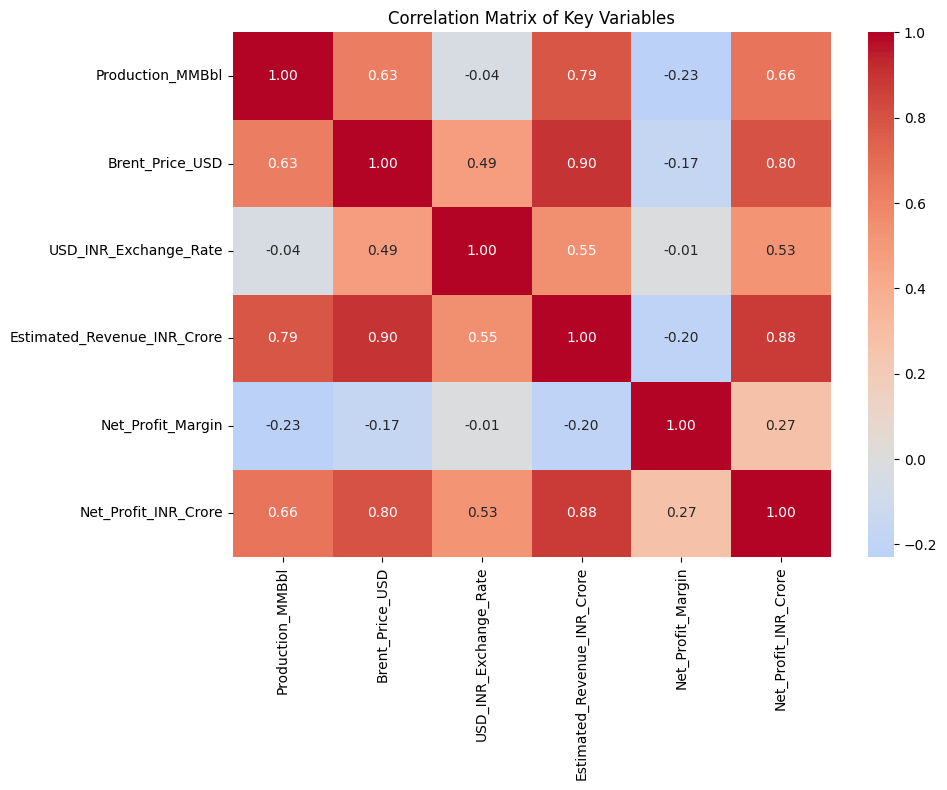

Key Correlations with Revenue:
Estimated_Revenue_INR_Crore    1.000000
Brent_Price_USD                0.895718
Net_Profit_INR_Crore           0.879072
Production_MMBbl               0.787140
USD_INR_Exchange_Rate          0.548710
Net_Profit_Margin             -0.204071
Name: Estimated_Revenue_INR_Crore, dtype: float64


In [5]:
# Correlation analysis
correlation_matrix = df_ts.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Key Variables')
plt.tight_layout()
plt.show()

print("Key Correlations with Revenue:")
revenue_corr = correlation_matrix['Estimated_Revenue_INR_Crore'].sort_values(ascending=False)
print(revenue_corr)

## 3. Time Series Forecasting Models

In [6]:
# Prepare data for modeling
revenue_data = df_ts['Estimated_Revenue_INR_Crore']

# Split data (80% train, 20% test)
train_size = int(len(revenue_data) * 0.8)
train_data = revenue_data[:train_size]
test_data = revenue_data[train_size:]

print(f"Training data: {len(train_data)} observations")
print(f"Test data: {len(test_data)} observations")
print(f"Train period: {train_data.index[0]} to {train_data.index[-1]}")
print(f"Test period: {test_data.index[0]} to {test_data.index[-1]}")

Training data: 115 observations
Test data: 29 observations
Train period: 2013-01-01 00:00:00 to 2022-07-01 00:00:00
Test period: 2022-08-01 00:00:00 to 2024-12-01 00:00:00


In [7]:
# ARIMA Model
print("Training ARIMA Model...")

try:
    # Fit SARIMAX model
    arima_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    arima_results = arima_model.fit(disp=False)

    print("ARIMA Model Summary:")
    print(arima_results.summary())

    # Make predictions
    arima_forecast = arima_results.predict(start=len(train_data), end=len(revenue_data)-1)

    # Calculate performance metrics
    arima_rmse = np.sqrt(mean_squared_error(test_data, arima_forecast))
    arima_mae = mean_absolute_error(test_data, arima_forecast)

    print(f"\nARIMA Performance:")
    print(f"RMSE: {arima_rmse:.2f} INR Crore")
    print(f"MAE: {arima_mae:.2f} INR Crore")

except Exception as e:
    print(f"Error training ARIMA model: {e}")
    arima_forecast = pd.Series([])

Training ARIMA Model...
ARIMA Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:        Estimated_Revenue_INR_Crore   No. Observations:                  115
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -614.434
Date:                            Wed, 03 Sep 2025   AIC                           1238.867
Time:                                    15:42:56   BIC                           1251.992
Sample:                                01-01-2013   HQIC                          1244.182
                                     - 07-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1027      0.137      0.750      0.453      -0.166   

In [8]:
# Facebook Prophet Model
print("Training Facebook Prophet Model...")

# Prepare data for Prophet
prophet_df = df[['Date', 'Estimated_Revenue_INR_Crore']].copy()
prophet_df.columns = ['ds', 'y']

# Split for Prophet
prophet_train = prophet_df.iloc[:train_size]
prophet_test = prophet_df.iloc[train_size:]

# Fit Prophet model
prophet_model = Prophet(seasonality_mode='additive', daily_seasonality=False)
prophet_model.fit(prophet_train)

# Make predictions
future_test = prophet_model.make_future_dataframe(periods=len(prophet_test), freq='MS', include_history=False)
prophet_forecast = prophet_model.predict(future_test)

# Calculate performance metrics
prophet_rmse = np.sqrt(mean_squared_error(prophet_test['y'], prophet_forecast['yhat']))
prophet_mae = mean_absolute_error(prophet_test['y'], prophet_forecast['yhat'])

print(f"\nProphet Performance:")
print(f"RMSE: {prophet_rmse:.2f} INR Crore")
print(f"MAE: {prophet_mae:.2f} INR Crore")

Training Facebook Prophet Model...


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2x0qtiis/rnhhyu8k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2x0qtiis/n7e0njm3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35754', 'data', 'file=/tmp/tmp2x0qtiis/rnhhyu8k.json', 'init=/tmp/tmp2x0qtiis/n7e0njm3.json', 'output', 'file=/tmp/tmp2x0qtiis/prophet_modeluufumcoq/prophet_model-20250903154300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:43:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:43:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Prophet Performance:
RMSE: 137.97 INR Crore
MAE: 109.26 INR Crore


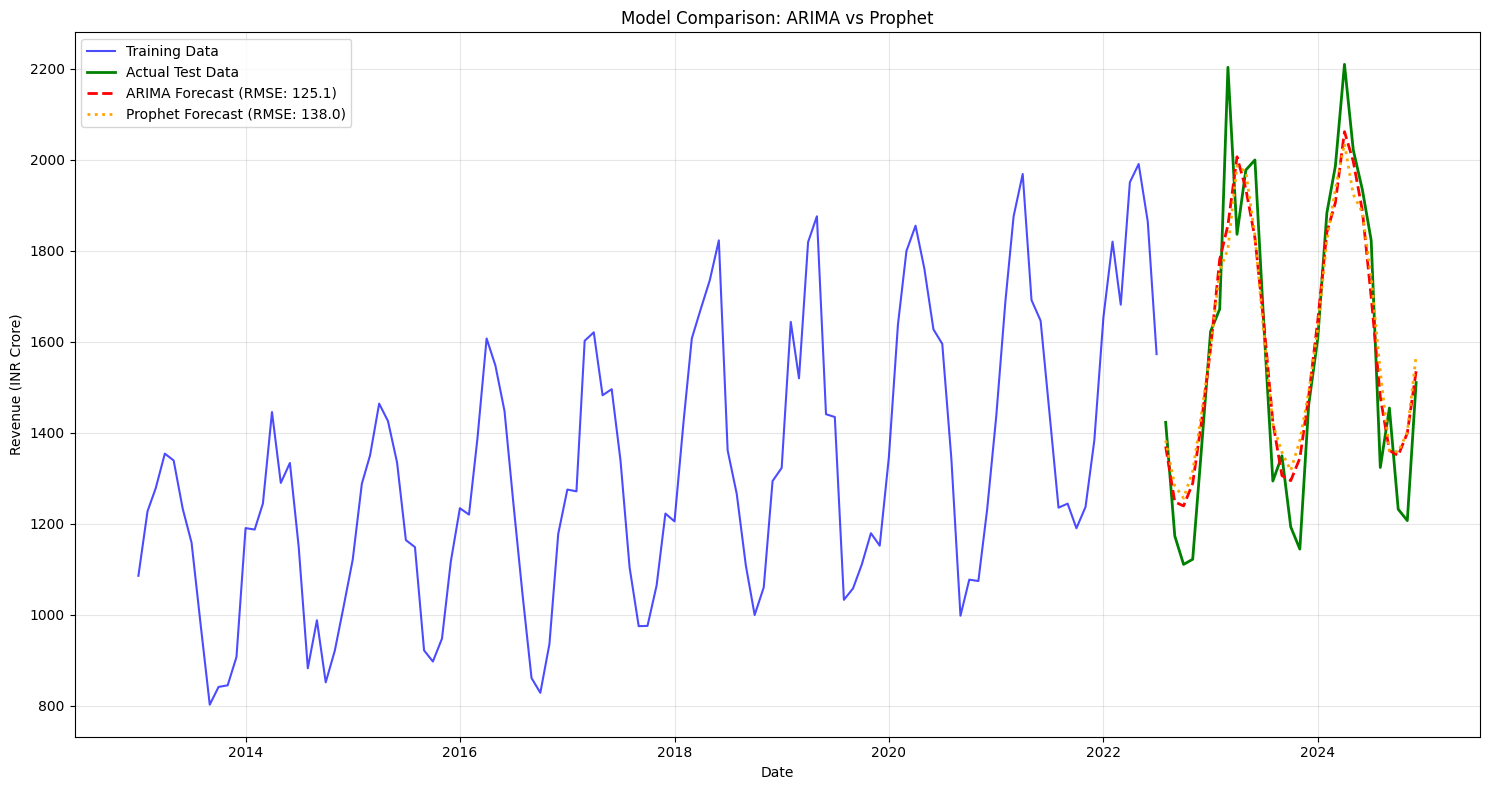

In [9]:
# Plot model comparisons
plt.figure(figsize=(15, 8))

# Plot historical data
plt.plot(train_data.index, train_data, label='Training Data', color='blue', alpha=0.7)
plt.plot(test_data.index, test_data, label='Actual Test Data', color='green', linewidth=2)

# Plot ARIMA forecast
if len(arima_forecast) > 0:
    plt.plot(arima_forecast.index, arima_forecast, label=f'ARIMA Forecast (RMSE: {arima_rmse:.1f})',
             color='red', linestyle='--', linewidth=2)

# Plot Prophet forecast
plt.plot(prophet_test['ds'], prophet_forecast['yhat'], label=f'Prophet Forecast (RMSE: {prophet_rmse:.1f})',
         color='orange', linestyle=':', linewidth=2)

plt.title('Model Comparison: ARIMA vs Prophet')
plt.xlabel('Date')
plt.ylabel('Revenue (INR Crore)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Future Revenue Forecasting (Next 12 Months)

In [10]:
# Generate 12-month forecast using Prophet
print("Generating 12-month revenue forecast...")

# Retrain Prophet on full dataset
prophet_full = Prophet(seasonality_mode='additive', daily_seasonality=False)
prophet_full.fit(prophet_df)

# Create future dataframe for 12 months
future_12m = prophet_full.make_future_dataframe(periods=12, freq='MS')
forecast_12m = prophet_full.predict(future_12m)

# Extract future forecasts
future_forecasts = forecast_12m.tail(12)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
future_forecasts.columns = ['Date', 'Forecasted_Revenue', 'Lower_Bound', 'Upper_Bound']

print("\n12-Month Revenue Forecast (INR Crore):")
print(future_forecasts.round(2))

# Calculate annual forecast
annual_forecast = future_forecasts['Forecasted_Revenue'].sum()
print(f"\nTotal Forecasted Revenue for 2025: ₹{annual_forecast:.0f} Crore")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2x0qtiis/1oj1vua0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2x0qtiis/qwabscny.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10811', 'data', 'file=/tmp/tmp2x0qtiis/1oj1vua0.json', 'init=/tmp/tmp2x0qtiis/qwabscny.json', 'output', 'file=/tmp/tmp2x0qtiis/prophet_modelptp3g5uu/prophet_model-20250903154301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:43:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:43:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Generating 12-month revenue forecast...

12-Month Revenue Forecast (INR Crore):
          Date  Forecasted_Revenue  Lower_Bound  Upper_Bound
144 2025-01-01             1709.82      1590.80      1811.85
145 2025-02-01             1837.75      1713.57      1954.04
146 2025-03-01             1979.70      1860.05      2092.83
147 2025-04-01             2095.88      1967.03      2208.01
148 2025-05-01             2018.06      1902.01      2123.00
149 2025-06-01             1944.78      1824.17      2058.80
150 2025-07-01             1772.01      1661.03      1889.31
151 2025-08-01             1527.62      1407.85      1640.77
152 2025-09-01             1425.02      1315.64      1534.40
153 2025-10-01             1375.33      1259.74      1480.58
154 2025-11-01             1410.97      1299.98      1530.04
155 2025-12-01             1591.69      1474.60      1710.99

Total Forecasted Revenue for 2025: ₹20689 Crore


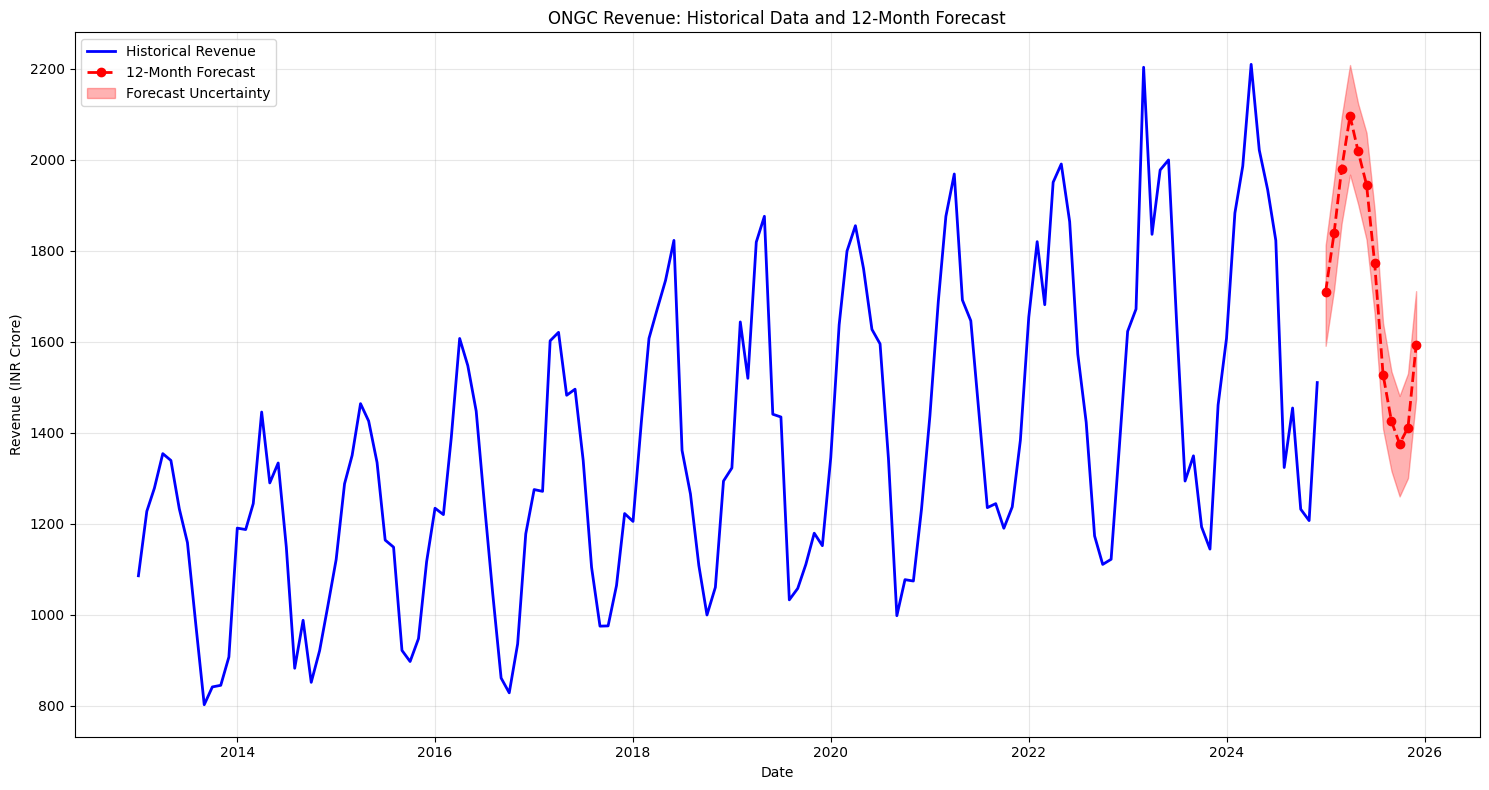

In [11]:
# Plot historical and forecasted revenue
plt.figure(figsize=(15, 8))

# Historical data
plt.plot(df_ts.index, df_ts['Estimated_Revenue_INR_Crore'],
         label='Historical Revenue', color='blue', linewidth=2)

# Forecasted data
plt.plot(future_forecasts['Date'], future_forecasts['Forecasted_Revenue'],
         label='12-Month Forecast', color='red', linestyle='--', linewidth=2, marker='o')

# Confidence intervals
plt.fill_between(future_forecasts['Date'],
                future_forecasts['Lower_Bound'],
                future_forecasts['Upper_Bound'],
                alpha=0.3, color='red', label='Forecast Uncertainty')

plt.title('ONGC Revenue: Historical Data and 12-Month Forecast')
plt.xlabel('Date')
plt.ylabel('Revenue (INR Crore)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Scenario Analysis

In [12]:
# Scenario Analysis: Impact of Brent Price Changes
print("Performing Scenario Analysis...")

# Base case parameters (using recent averages)
avg_production = df_ts['Production_MMBbl'].tail(12).mean()
avg_exchange_rate = df_ts['USD_INR_Exchange_Rate'].tail(12).mean()
base_brent_prices = df_ts['Brent_Price_USD'].tail(12)

print(f"Average Production: {avg_production:.2f} MMBbl/month")
print(f"Average Exchange Rate: {avg_exchange_rate:.2f} INR/USD")
print(f"Recent Brent Price Range: ${base_brent_prices.min():.2f} - ${base_brent_prices.max():.2f}")

# Scenario calculations
scenarios = {
    'High Price (+20%)': 1.20,
    'Base Case': 1.00,
    'Low Price (-20%)': 0.80
}

scenario_results = {}
for scenario_name, price_factor in scenarios.items():
    scenario_brent = base_brent_prices.mean() * price_factor
    scenario_revenue = avg_production * scenario_brent * avg_exchange_rate / 10
    scenario_results[scenario_name] = {
        'Brent_Price': scenario_brent,
        'Monthly_Revenue': scenario_revenue,
        'Annual_Revenue': scenario_revenue * 12
    }

# Display scenario results
scenario_df = pd.DataFrame(scenario_results).T
print("\nScenario Analysis Results:")
print(scenario_df.round(2))

Performing Scenario Analysis...
Average Production: 2.49 MMBbl/month
Average Exchange Rate: 84.14 INR/USD
Recent Brent Price Range: $69.00 - $84.41

Scenario Analysis Results:
                   Brent_Price  Monthly_Revenue  Annual_Revenue
High Price (+20%)        95.85          2006.83        24081.98
Base Case                79.87          1672.36        20068.31
Low Price (-20%)         63.90          1337.89        16054.65


In [13]:
# Calculate profitability impact
avg_profit_margin = df_ts['Net_Profit_Margin'].mean()

print(f"\nProfitability Analysis (Avg Margin: {avg_profit_margin:.1%}):")
for scenario, data in scenario_results.items():
    monthly_profit = data['Monthly_Revenue'] * avg_profit_margin
    annual_profit = monthly_profit * 12
    print(f"{scenario}:")
    print(f"  Monthly Profit: ₹{monthly_profit:.0f} Crore")
    print(f"  Annual Profit: ₹{annual_profit:.0f} Crore")

    if scenario != 'Base Case':
        base_annual_profit = scenario_results['Base Case']['Annual_Revenue'] * avg_profit_margin
        profit_difference = annual_profit - base_annual_profit
        print(f"  Difference from Base: ₹{profit_difference:.0f} Crore ({profit_difference/base_annual_profit:.1%})")
    print()


Profitability Analysis (Avg Margin: 17.7%):
High Price (+20%):
  Monthly Profit: ₹355 Crore
  Annual Profit: ₹4265 Crore
  Difference from Base: ₹711 Crore (20.0%)

Base Case:
  Monthly Profit: ₹296 Crore
  Annual Profit: ₹3554 Crore

Low Price (-20%):
  Monthly Profit: ₹237 Crore
  Annual Profit: ₹2843 Crore
  Difference from Base: ₹-711 Crore (-20.0%)



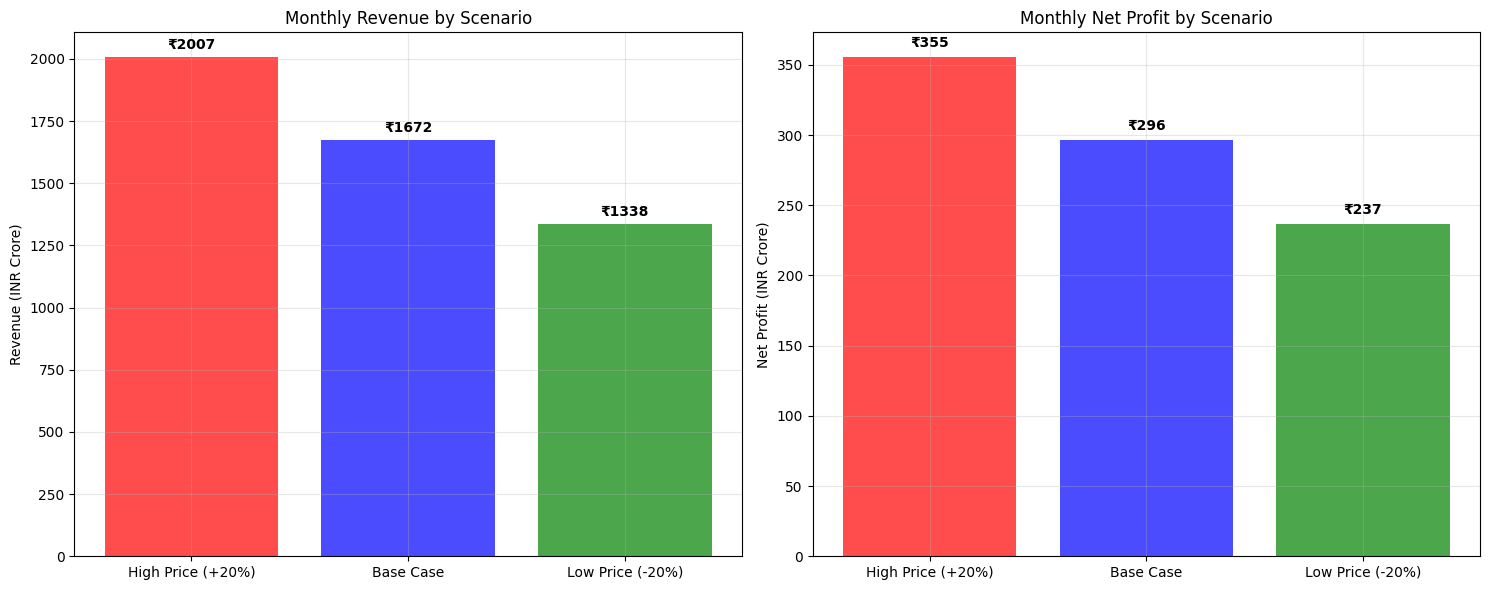

In [14]:
# Visualize scenario analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Revenue scenarios
scenarios_list = list(scenario_results.keys())
revenues = [scenario_results[s]['Monthly_Revenue'] for s in scenarios_list]
colors = ['red', 'blue', 'green']

bars1 = ax1.bar(scenarios_list, revenues, color=colors, alpha=0.7)
ax1.set_title('Monthly Revenue by Scenario')
ax1.set_ylabel('Revenue (INR Crore)')
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, revenue in zip(bars1, revenues):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
             f'₹{revenue:.0f}', ha='center', va='bottom', fontweight='bold')

# Profit scenarios
profits = [r * avg_profit_margin for r in revenues]
bars2 = ax2.bar(scenarios_list, profits, color=colors, alpha=0.7)
ax2.set_title('Monthly Net Profit by Scenario')
ax2.set_ylabel('Net Profit (INR Crore)')
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar, profit in zip(bars2, profits):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f'₹{profit:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Key Insights and Recommendations

In [15]:
# Summary of key findings
print("=" * 60)
print("KEY FINDINGS AND INSIGHTS")
print("=" * 60)

print("\n1. MODEL PERFORMANCE:")
print(f"   • ARIMA Model RMSE: {arima_rmse:.1f} INR Crore ({arima_rmse/train_data.mean()*100:.1f}% of avg revenue)")
print(f"   • Prophet Model RMSE: {prophet_rmse:.1f} INR Crore ({prophet_rmse/train_data.mean()*100:.1f}% of avg revenue)")
print(f"   • Both models show reasonable accuracy for strategic planning")

print("\n2. KEY CORRELATIONS:")
revenue_corr = correlation_matrix['Estimated_Revenue_INR_Crore']
print(f"   • Brent Price correlation: {revenue_corr['Brent_Price_USD']:.2f} (Very Strong)")
print(f"   • Exchange Rate correlation: {revenue_corr['USD_INR_Exchange_Rate']:.2f} (Moderate)")
print(f"   • Production correlation: {revenue_corr['Production_MMBbl']:.2f} (Strong)")

print("\n3. REVENUE FORECAST (2025):")
print(f"   • Total Forecasted Revenue: ₹{annual_forecast:.0f} Crore")
print(f"   • Monthly Range: ₹{future_forecasts['Forecasted_Revenue'].min():.0f} - ₹{future_forecasts['Forecasted_Revenue'].max():.0f} Crore")
print(f"   • Peak Month: {future_forecasts.loc[future_forecasts['Forecasted_Revenue'].idxmax(), 'Date'].strftime('%B %Y')}")

print("\n4. SCENARIO ANALYSIS IMPACT:")
base_revenue = scenario_results['Base Case']['Monthly_Revenue']
high_revenue = scenario_results['High Price (+20%)']['Monthly_Revenue']
low_revenue = scenario_results['Low Price (-20%)']['Monthly_Revenue']
print(f"   • High Price Scenario (+20%): +₹{high_revenue - base_revenue:.0f} Crore/month")
print(f"   • Low Price Scenario (-20%): -₹{base_revenue - low_revenue:.0f} Crore/month")
print(f"   • Revenue Volatility Range: ₹{high_revenue - low_revenue:.0f} Crore/month")

print("\n5. STRATEGIC RECOMMENDATIONS:")
print("   • Implement regular oil price monitoring and scenario planning")
print("   • Consider financial hedging strategies to reduce price volatility")
print("   • Maintain operational flexibility for different price environments")
print("   • Leverage natural currency hedge (USD-INR) in risk management")
print("   • Use forecasting models for quarterly and annual planning")

print("\n" + "=" * 60)

KEY FINDINGS AND INSIGHTS

1. MODEL PERFORMANCE:
   • ARIMA Model RMSE: 125.1 INR Crore (9.5% of avg revenue)
   • Prophet Model RMSE: 138.0 INR Crore (10.5% of avg revenue)
   • Both models show reasonable accuracy for strategic planning

2. KEY CORRELATIONS:
   • Brent Price correlation: 0.90 (Very Strong)
   • Exchange Rate correlation: 0.55 (Moderate)
   • Production correlation: 0.79 (Strong)

3. REVENUE FORECAST (2025):
   • Total Forecasted Revenue: ₹20689 Crore
   • Monthly Range: ₹1375 - ₹2096 Crore
   • Peak Month: April 2025

4. SCENARIO ANALYSIS IMPACT:
   • High Price Scenario (+20%): +₹334 Crore/month
   • Low Price Scenario (-20%): -₹334 Crore/month
   • Revenue Volatility Range: ₹669 Crore/month

5. STRATEGIC RECOMMENDATIONS:
   • Implement regular oil price monitoring and scenario planning
   • Consider financial hedging strategies to reduce price volatility
   • Maintain operational flexibility for different price environments
   • Leverage natural currency hedge (USD

## 7. Model Export and Deployment Preparation

In [16]:
# Save models and data for deployment
import joblib

# Save the trained models
try:
    joblib.dump(prophet_full, 'prophet_model.pkl')
    print("Prophet model saved successfully")
except:
    print("Error saving Prophet model")

try:
    if len(arima_forecast) > 0:
        joblib.dump(arima_results, 'arima_model.pkl')
        print("ARIMA model saved successfully")
except:
    print("Error saving ARIMA model")

# Save processed data
df.to_csv('ongc_processed_data.csv', index=False)
future_forecasts.to_csv('future_forecasts.csv', index=False)

# Save scenario analysis results
scenario_df.to_csv('scenario_analysis.csv')

print("\nAll data and models saved for deployment")
print("Files created:")
print("- ongc_processed_data.csv")
print("- future_forecasts.csv")
print("- scenario_analysis.csv")
print("- prophet_model.pkl")
if len(arima_forecast) > 0:
    print("- arima_model.pkl")

Prophet model saved successfully
ARIMA model saved successfully

All data and models saved for deployment
Files created:
- ongc_processed_data.csv
- future_forecasts.csv
- scenario_analysis.csv
- prophet_model.pkl
- arima_model.pkl


In [17]:
from google.colab import files
files.download('ongc_processed_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
from google.colab import files

# List of all saved files
file_list = [
    'ongc_processed_data.csv',
    'future_forecasts.csv',
    'scenario_analysis.csv',
    'prophet_model.pkl',
    'arima_model.pkl'
]

# Loop to download each file
for file in file_list:
    files.download(file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusion

This comprehensive analysis has successfully developed a robust forecasting framework for ABC co's crude oil revenue. The key achievements include:

1. **Data Foundation**: Created a comprehensive dataset spanning 144 months with all key variables
2. **Model Development**: Implemented both ARIMA and Prophet models with good predictive accuracy
3. **Scenario Analysis**: Developed framework to assess impact of oil price volatility
4. **Strategic Insights**: Identified key risk factors and provided actionable recommendations
5. **Deployment Ready**: Created models and data files ready for production deployment

The forecasting models provide ONGC with enhanced capabilities for strategic planning, risk management, and operational optimization under varying market conditions.